# Figure Plotter

In this notebook, we will plot some new pdf figure to input in our report. The following section is the illustrator of our figures.

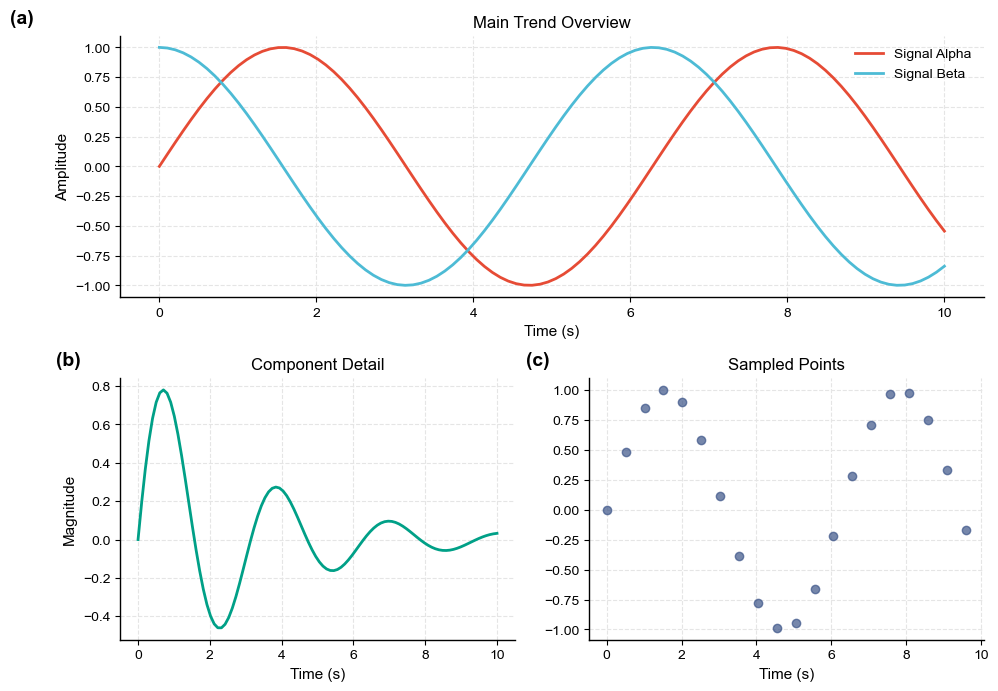

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 第一部分：应用全局报告样式 (让你告别丑陋的默认图)
# ==========================================
report_style = {
    "pdf.fonttype": 42, "ps.fonttype": 42, "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"], 
    "font.size": 10, "axes.titlesize": 12, "axes.labelsize": 11,
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 1.0, "axes.axisbelow": True,
    "axes.grid": True, "grid.color": "#E5E5E5", "grid.linestyle": "--",
    "legend.frameon": False,
    # 经典 Science/Nature 高级配色
    "axes.prop_cycle": plt.cycler('color', ['#E64B35', '#4DBBD5', '#00A087', '#3C5488']),
    "lines.linewidth": 2.0, "figure.autolayout": True, 
    "savefig.bbox": "tight", "savefig.transparent": True
}
plt.rcParams.update(report_style)

# ==========================================
# 第二部分：生成一些模拟数据
# ==========================================
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.exp(-x/3) * np.sin(2*x)

# ==========================================
# 第三部分：使用 subplot_mosaic 魔法进行拼图！
# ==========================================
# 用字母直观地“画”出你的排版：
# 第一行全是 'A' (跨两列)
# 第二行左边是 'B'，右边是 'C'
layout = """
    AA
    BC
"""

# figsize 控制整张拼图画布的物理尺寸 (宽, 高)，单位是英寸
fig, axes = plt.subplot_mosaic(layout, figsize=(10, 7))

# -----------------
# 填充图 A (主图)
# -----------------
# axes['A'] 就代表拿到了布局里 A 的那块地盘
axes['A'].plot(x, y1, label='Signal Alpha')
axes['A'].plot(x, y2, label='Signal Beta')
axes['A'].set_title('Main Trend Overview')
axes['A'].set_xlabel('Time (s)')
axes['A'].set_ylabel('Amplitude')
axes['A'].legend()

# -----------------
# 填充图 B (左下图)
# -----------------
axes['B'].plot(x, y3, color='#00A087', label='Decay Component') # 可以单独指定颜色
axes['B'].set_title('Component Detail')
axes['B'].set_xlabel('Time (s)')
axes['B'].set_ylabel('Magnitude')

# -----------------
# 填充图 C (右下图：假设是个散点图)
# -----------------
axes['C'].scatter(x[::5], y1[::5], color='#3C5488', alpha=0.7)
axes['C'].set_title('Sampled Points')
axes['C'].set_xlabel('Time (s)')

# ==========================================
# 第四部分：一键导出无损 PDF
# ==========================================
# 为报告或论文加上 a, b, c 的小标（学术圈非常需要这个）
for label, ax in axes.items():
    # 在每个子图的左上角标上 (a), (b), (c)
    ax.text(-0.1, 1.1, f'({label.lower()})', transform=ax.transAxes, 
            fontsize=14, fontweight='bold', va='top', ha='right')

# plt.savefig('final_report_plot.pdf')
plt.show() # 如果你想在跑代码时顺便预览一下，可以取消注释这行

The first plot will demonstrate the region of Salish Sea and the range of our numerical model.

## Methods


完成！带框图例 + 倾斜文字的终极图已保存至: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_svg/Map.pdf


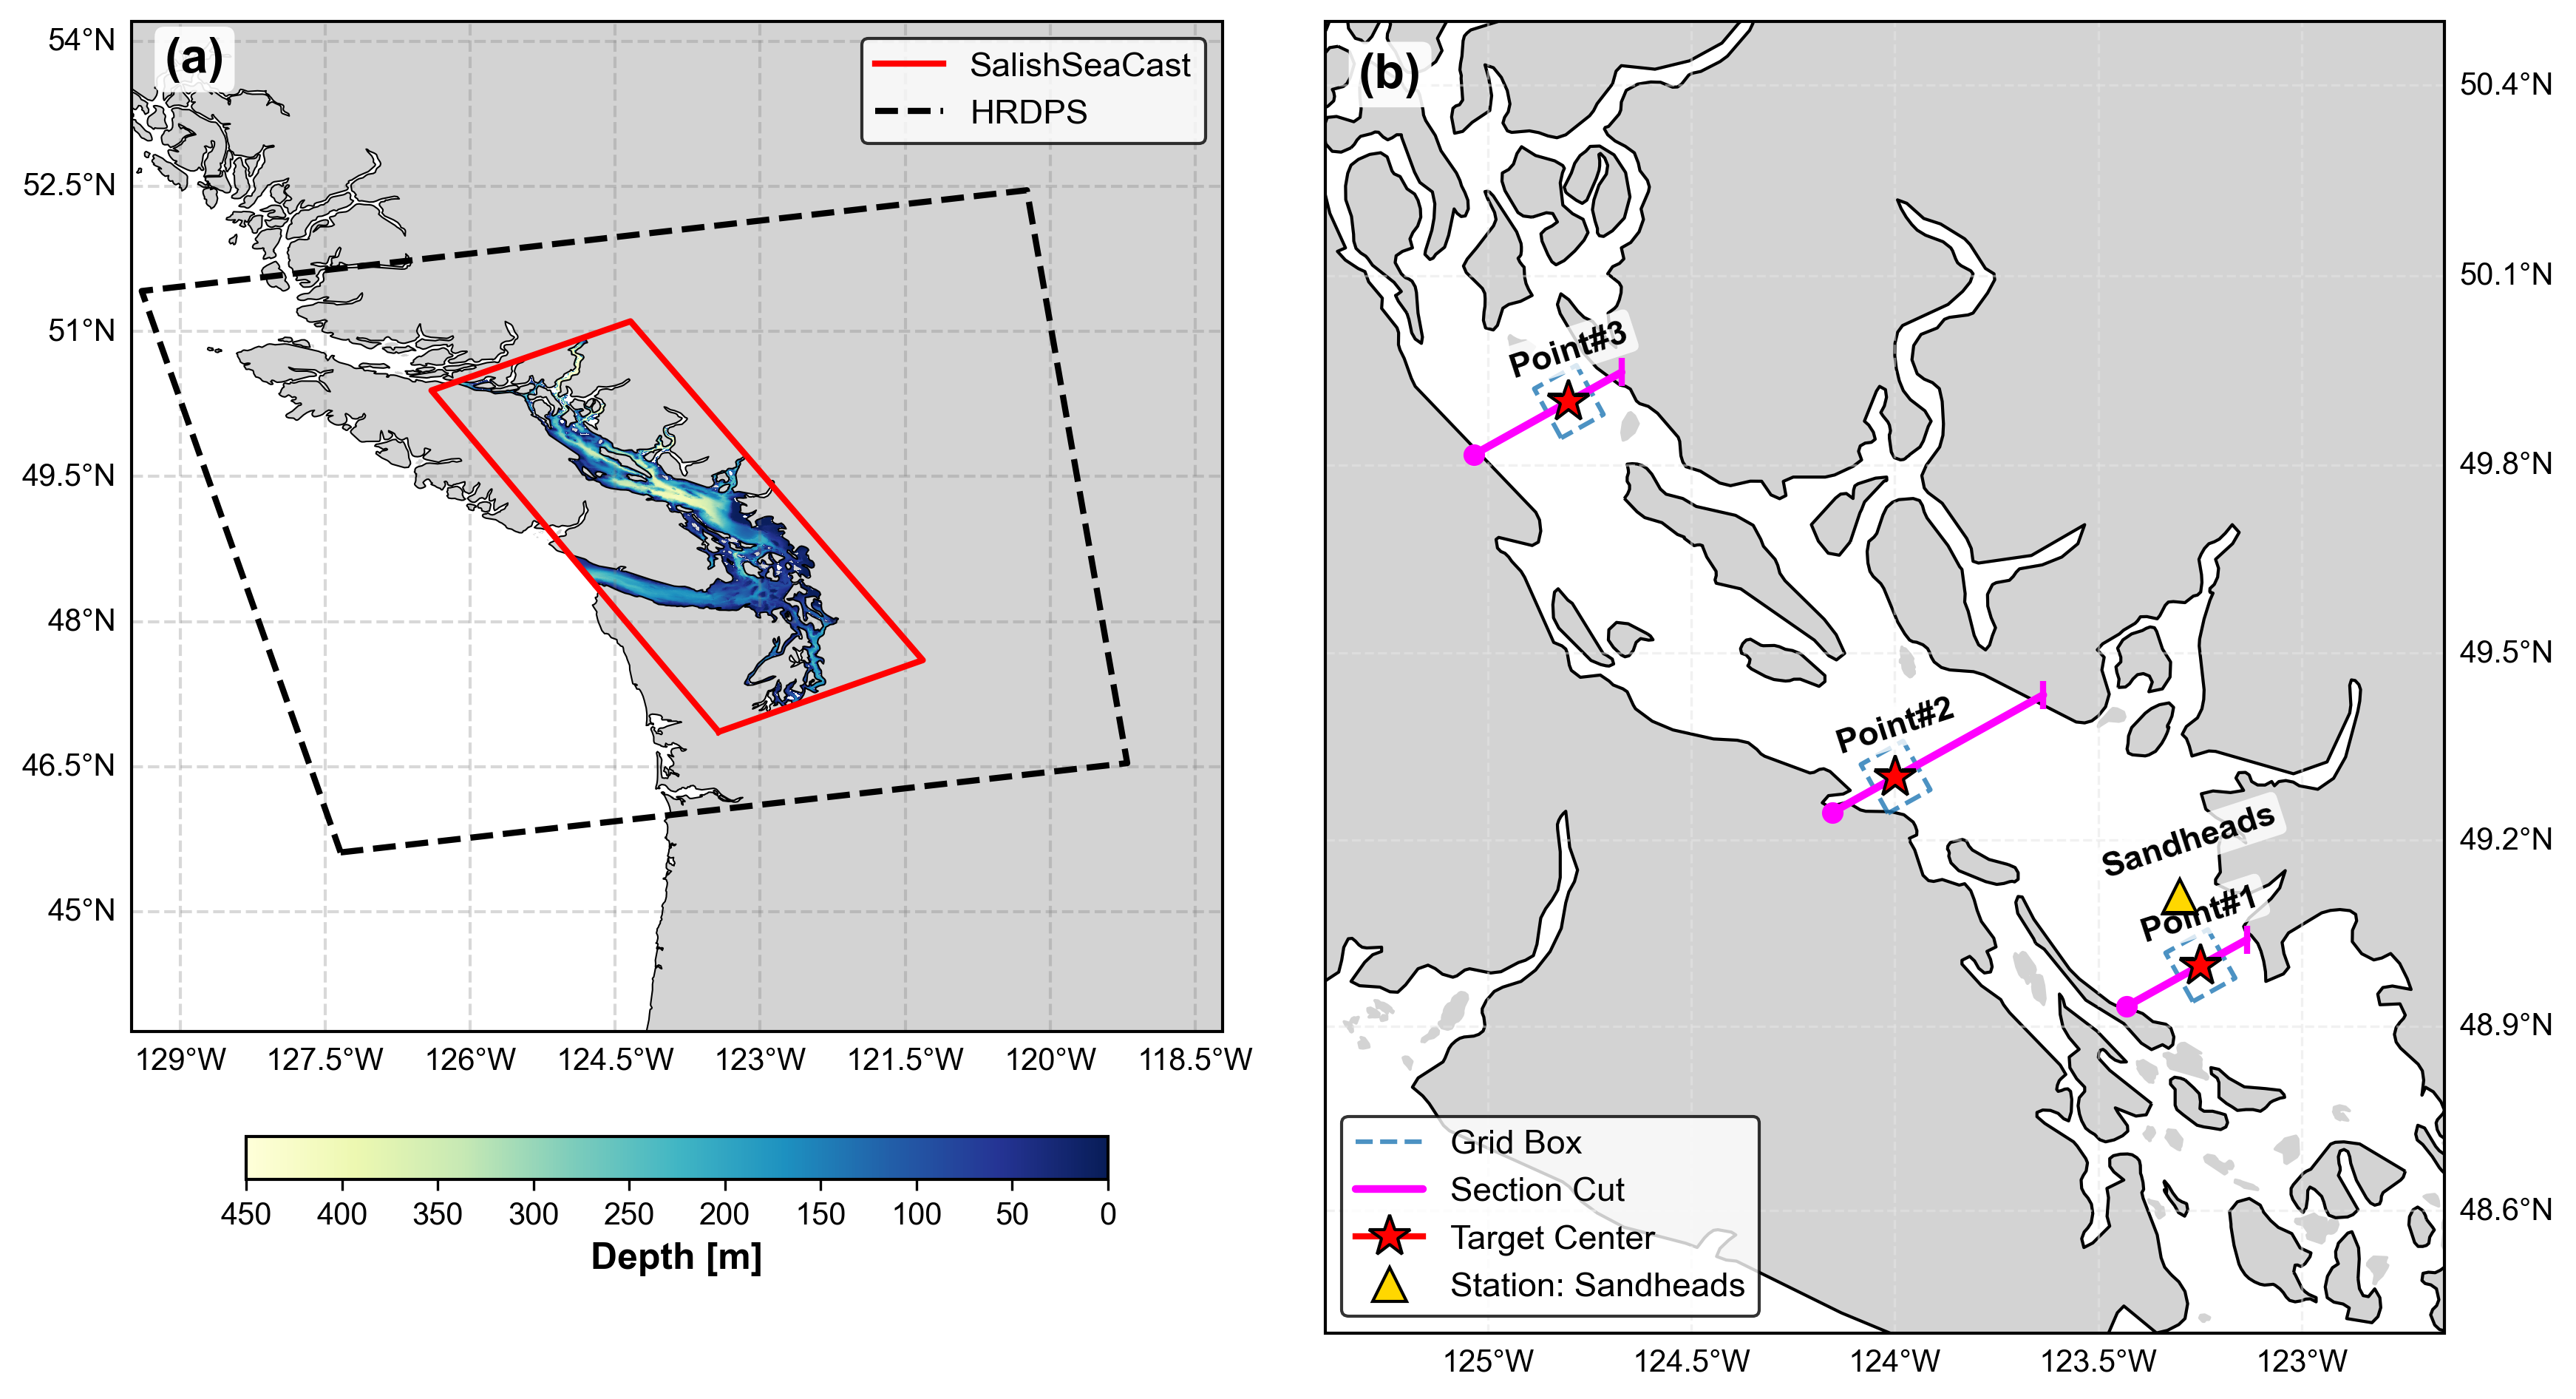

In [ ]:
# Region Show

import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



# ==========================================
# 1. 配置文件与路径 (请根据你的实际路径调整)
# ==========================================

BATHY_FILE = "/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc"
WIND_FILE = "/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2007m01d03.nc"

BASE_DIR = '/results2/SalishSea/nowcast-green.201905/'
SAMPLE_FILE_PATH = os.path.join(BASE_DIR, '01jun18/SalishSea_1d_20180601_20180601_grid_T.nc')
OUTPUT_DIR = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TARGETS_DEFINITIONS = {
    'Point_1': {'value': (49.0, -123.25), 'label': 'Point#1'},
    'Point_2': {'value': (49.3, -124.0),  'label': 'Point#2'},
    'Point_3': {'value': (49.9, -124.8),  'label': 'Point#3'},
}

STATIONS_DEFINITIONS = {
    'SH': {'lat': 49.11, 'lon': -123.3, 'label': 'Sandheads',  'color': 'gold'}
}

GRID_BOX_RADIUS = 10 
SECTION_CONFIG = {
    'Point_1': {'left_offset': 35, 'right_offset': 22},
    'Point_2': {'left_offset': 30, 'right_offset': 70}, 
    'Point_3': {'left_offset': 45, 'right_offset': 25},
}

VAR_LAT = 'nav_lat'
VAR_LON = 'nav_lon'

# ==========================================
# 2. 辅助函数合集
# ==========================================

def get_valid_boundary(lon_grid, lat_grid):
    valid_mask = (np.abs(lon_grid) > 1e-3) & (np.abs(lat_grid) > 1e-3)
    rows, cols = np.where(valid_mask)
    if len(rows) == 0:
        raise ValueError("Grid contains only zeros or invalid coordinates!")
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()
    corners_idx = [
        (min_row, min_col), (min_row, max_col), 
        (max_row, max_col), (max_row, min_col), (min_row, min_col)
    ]
    return [lon_grid[r, c] for r, c in corners_idx], [lat_grid[r, c] for r, c in corners_idx]

def load_grid(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Grid file not found: {file_path}")
    with nc.Dataset(file_path, 'r') as ds:
        return ds.variables[VAR_LAT][:], ds.variables[VAR_LON][:]

def find_nearest_index(lat_2d, lon_2d, target_lat, target_lon):
    dist_sq = (lat_2d - target_lat)**2 + (lon_2d - target_lon)**2
    min_idx_flat = dist_sq.argmin()
    return np.unravel_index(min_idx_flat, lat_2d.shape)

def get_parallelogram_coords(lat_2d, lon_2d, cy, cx, radius):
    ny, nx = lat_2d.shape
    y_min, y_max = max(0, cy - radius), min(ny - 1, cy + radius)
    x_min, x_max = max(0, cx - radius), min(nx - 1, cx + radius)
    lats = [lat_2d[y_min, x_min], lat_2d[y_max, x_min], lat_2d[y_max, x_max], lat_2d[y_min, x_max], lat_2d[y_min, x_min]]
    lons = [lon_2d[y_min, x_min], lon_2d[y_max, x_min], lon_2d[y_max, x_max], lon_2d[y_min, x_max], lon_2d[y_min, x_min]]
    return lons, lats

def get_section_line_coords(lat_2d, lon_2d, cy, cx, config):
    ny, nx = lat_2d.shape
    x_start = max(0, cx - config['left_offset'])
    x_end = min(nx - 1, cx + config['right_offset'])
    return lon_2d[cy, x_start:x_end+1], lat_2d[cy, x_start:x_end+1], (cy, x_start), (cy, x_end)

# ==========================================
# 3. 主程序 - 绘图缝合 (A4 紧凑优化版)
# ==========================================
def main():
    with nc.Dataset(BATHY_FILE, 'r') as ds:
        ss_lons, ss_lats = ds.variables['nav_lon'][:], ds.variables['nav_lat'][:]
        bathy = ds.variables['Bathymetry'][:]
    with nc.Dataset(WIND_FILE, 'r') as ds:
        wind_lons, wind_lats = ds.variables['nav_lon'][:], ds.variables['nav_lat'][:]
    
    ss_bound_x, ss_bound_y = get_valid_boundary(ss_lons, ss_lats)
    wind_bound_x, wind_bound_y = get_valid_boundary(wind_lons, wind_lats)

    lat_2d, lon_2d = load_grid(SAMPLE_FILE_PATH)
    results = {}
    for key, info in TARGETS_DEFINITIONS.items():
        t_lat, t_lon = info['value']
        y_idx, x_idx = find_nearest_index(lat_2d, lon_2d, t_lat, t_lon)
        box_lons, box_lats = get_parallelogram_coords(lat_2d, lon_2d, y_idx, x_idx, GRID_BOX_RADIUS)
        sec_config = SECTION_CONFIG.get(key, {'left_offset': 20, 'right_offset': 20})
        sec_lons, sec_lats, _, _ = get_section_line_coords(lat_2d, lon_2d, y_idx, x_idx, sec_config)
        results[key] = {
            'label': info['label'], 'y_idx': y_idx, 'x_idx': x_idx,
            'center_coords': (lat_2d[y_idx, x_idx], lon_2d[y_idx, x_idx]),
            'box_coords': (box_lons, box_lats), 'section_coords': (sec_lons, sec_lats)
        }

    fig = plt.figure(figsize=(12, 6.5), dpi=300)

    # ---------------------------------------------------------
    # 子图 (a): 宏观边界与深度图
    # ---------------------------------------------------------
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
    
    pcm = ax1.pcolormesh(ss_lons, ss_lats, bathy, transform=ccrs.PlateCarree(),
                         cmap='YlGnBu_r', vmin=0, vmax=450, rasterized=True) 
    ax1.add_feature(cfeature.LAND, facecolor='#d3d3d3', edgecolor='none', zorder=2)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=3)

    ax1.plot(ss_bound_x, ss_bound_y, transform=ccrs.PlateCarree(), 
             color='red', linewidth=2, linestyle='-', zorder=10, label='SalishSeaCast')
    ax1.plot(wind_bound_x, wind_bound_y, transform=ccrs.PlateCarree(), 
             color='black', linewidth=2, linestyle='--', zorder=10, label='HRDPS')

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False 
    gl1.xformatter = LONGITUDE_FORMATTER
    gl1.yformatter = LATITUDE_FORMATTER
    gl1.xlabel_style = {'size': 10}
    gl1.ylabel_style = {'size': 10}

    # 【修改点 1】: 强制显示半透明白框，加上黑边
    ax1.legend(loc='upper right', fontsize=11, frameon=True, facecolor='white', edgecolor='black', framealpha=0.8)
    
    cbar = plt.colorbar(pcm, ax=ax1, orientation='horizontal', pad=0.08, shrink=0.75)
    cbar.ax.invert_xaxis()
    cbar.set_label('Depth [m]', fontsize=12, fontweight='bold')

    buff = 3.1 
    ax1.set_extent([np.min(ss_lons) - buff, np.max(ss_lons) + buff,
                    np.min(ss_lats) - buff, np.max(ss_lats) + buff])
    
    ax1.text(0.03, 0.95, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'), zorder=20)

    # ---------------------------------------------------------
    # 子图 (b): 微观目标点与网格切片
    # ---------------------------------------------------------
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Mercator(central_longitude=-124))
    
    all_lons = [pt['value'][1] for pt in TARGETS_DEFINITIONS.values()]
    all_lats = [pt['value'][0] for pt in TARGETS_DEFINITIONS.values()]
    margin = 0.6
    ax2.set_extent([min(all_lons)-margin, max(all_lons)+margin, 
                    min(all_lats)-margin, max(all_lats)+margin], crs=ccrs.PlateCarree())

    ax2.add_feature(cfeature.LAND, color='lightgray', zorder=1)
    ax2.add_feature(cfeature.COASTLINE, linewidth=1, zorder=2)
    gl2 = ax2.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl2.top_labels = False
    gl2.left_labels = False 
    gl2.xlabel_style = {'size': 10}
    gl2.ylabel_style = {'size': 10}

    for i, (key, res) in enumerate(results.items()):
        color = '#1f77b4'
        box_lons, box_lats = res['box_coords']
        ax2.plot(box_lons, box_lats, transform=ccrs.PlateCarree(), 
                 color=color, linestyle='--', linewidth=1.5, alpha=0.8, label=f"Grid Box" if i==0 else "")
        
        sec_lons, sec_lats = res['section_coords']
        ax2.plot(sec_lons, sec_lats, transform=ccrs.PlateCarree(), color='magenta', linewidth=2.5, solid_capstyle='round', zorder=5, label=f"Section Cut" if i==0 else "")
        ax2.plot(sec_lons[0], sec_lats[0], transform=ccrs.PlateCarree(), marker='o', color='magenta', markersize=6, zorder=6)
        ax2.plot(sec_lons[-1], sec_lats[-1], transform=ccrs.PlateCarree(), marker='|', color='magenta', markersize=9, markeredgewidth=2, zorder=6)

        cy_lat, cx_lon = res['center_coords']
        ax2.plot(cx_lon, cy_lat, transform=ccrs.PlateCarree(), marker='*', color='red', markersize=14, zorder=10, markeredgecolor='black', label='Target Center' if i==0 else "")
        
        # 顺手把 Point 文字也往上提了一点点 (+0.04)
        ax2.text(cx_lon, cy_lat + 0.04, res['label'], transform=ccrs.PlateCarree(), 
                 horizontalalignment='center', fontsize=11, fontweight='bold', rotation=18,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'),zorder=10)
        
    for s_id, s_info in STATIONS_DEFINITIONS.items():
        s_lon, s_lat, s_label, s_color = s_info['lon'], s_info['lat'], s_info['label'], s_info.get('color', 'black')
        ax2.plot(s_lon, s_lat, transform=ccrs.PlateCarree(), marker='^', color=s_color, markersize=11, markeredgecolor='black', zorder=15, linestyle='None', label=f"Station: {s_label}")
        
        # 【修改点 2】: 站点文字上提 (s_lat+0.06)，向左微调 (s_lon-0.12)，并旋转15度 (rotation=15)
        ax2.text(s_lon-0.2, s_lat+0.02, s_label, transform=ccrs.PlateCarree(), 
                 fontsize=11, fontweight='bold', color='black', verticalalignment='bottom', 
                 rotation=18, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'),zorder=15)

    # 【修改点 1】: 右图的图例也加上半透明白框
    ax2.legend(loc='lower left', fontsize=11, frameon=True, facecolor='white', edgecolor='black', framealpha=0.8)

    ax2.text(0.03, 0.95, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'), zorder=20)

    plt.tight_layout(pad=1.5, w_pad=1.0) 
    
    out_file = os.path.join(OUTPUT_DIR, "Map.pdf")
    plt.savefig(out_file, format='pdf', bbox_inches='tight', dpi=300)
    print(f"完成！带框图例 + 倾斜文字的终极图已保存至: {out_file}")
    plt.show()

if __name__ == "__main__":
    main()


### Modeling Framework and Forcing Data

The physical and biogeochemical dynamics of the region were simulated using the SalishSeaCast model, a three-dimensional coupled bio-physical ocean model with a high horizontal resolution of approximately 500 m. The spatial domain and bathymetry of the SalishSeaCast model are delineated in Figure 1a (red box). Surface atmospheric forcing for the ocean model was provided by the High-Resolution Deterministic Prediction System (HRDPS), which operates at a 2.5 km resolution. As shown in Figure 1a, the HRDPS wind model domain (black dashed box) entirely encompasses the SalishSeaCast domain.

Riverine input, a critical driver of the Salish Sea's estuarine circulation, was also incorporated. Specifically, discharge from the Fraser River was distributed among its three main arms based on regional mapping (BCCF and WA maps) and historical literature (Thomson, 1981). In the model's watershed configuration, the Fraser River is assumed to contribute 98% of the regional freshwater discharge, while the remaining 2% is attributed to smaller U.S. rivers to the south (WRIA 1).

### Data Extraction and Study Sites

Model outputs were extracted over a 10-year period from 2010 to 2019. While the native model output possesses an hourly temporal resolution, the data were subjected to various temporal averagings (e.g., daily or monthly means) to facilitate the analysis and visualization of long-term trends. The primary variables extracted for this study included physical parameters (temperature and salinity) and biological parameters (diatom and flagellate concentrations). To provide empirical context and validate the local atmospheric forcing, continuous observational wind field data from the Sandheads station (Figure 1b) were utilized.

To investigate spatial variations and vertical dynamics within the strait, three specific target points and corresponding cross-strait transects were selected (Figure 1b). These transects are strategically distributed along the longitudinal axis of the Strait of Georgia, representing the northern (Point#3), central (Point#2), and southern (Point#1) regions. Furthermore, to capture cross-basin asymmetries, the target centers were explicitly positioned on the western side, central channel, and eastern side of the strait, respectively. The cross-strait transects (magenta lines) were established across these points to analyze the upper 50 m of the water column, a depth range chosen to effectively capture stratification variations and detect wind-driven coastal upwelling events.